#<b>Final Submission


###<b> Mounting the Drive

In [5]:

#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Using a GPU to Increase Speed**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
## Testing speed of GPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.5967451519999827
GPU (s):
0.06155527399999983
GPU speedup over CPU: 58x


###<b>Loading libraries</b>

In [3]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [6]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Capstone MIT 2021/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

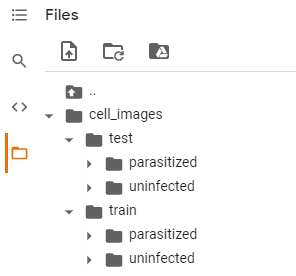

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [7]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [8]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [9]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [10]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [11]:
# shape of images
train_images.shape, test_images.shape

((24958, 64, 64, 3), (2600, 64, 64, 3))

###<b> Checking the shape of train and test labels

In [12]:
# shape of labels 
train_labels.shape, test_labels.shape

((24958,), (2600,))

#####<b> Observations and insights: _____
There are nearly 25K imsages in the training data and 2.6K in the test data. These images are 64X64 pixels and have 3 dimensions.  The labels are just a singular column of 1's and 0's (1 for infected and 0 for uninfected). They have the same number of observations respectively as in the train/test image data.

### <b>Check the minimum and maximum range of pixel values for train and test images

In [11]:
# try to use min and max function from numpy
train_max = np.amax(train_images)
train_min = np.amin(train_images)
test_max = np.amax(test_images)
test_min = np.amin(test_images)
print(train_max, train_min, test_max, test_min)

255 0 255 0


#####<b> Observations and insights: The maximum number of pixels is 255 and the minimum is 0. This is true for both the training and test data.




###<b> Count the number of values in both uninfected and parasitized 

In [12]:
# try to use value_counts to count the values
pd.value_counts(train_labels)

1    12479
0    12479
dtype: int64

In [13]:
pd.value_counts(test_labels)

1    1300
0    1300
dtype: int64

###<b>Normalize the images

In [13]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

#####<b> Observations and insights: _____
There are nearly 25K imsages in the training data and 2.6K in the test data. These images are 64X64 pixels and have 3 dimensions.  The labels are just a singular column of 1's and 0's (1 for infected and 0 for uninfected). They have the same number of observations respectively as in the train/test image data.

###<b> Count the number of values in both uninfected and parasitized 

In [16]:
# try to use value_counts to count the values
pd.value_counts(train_labels)

1    12479
0    12479
dtype: int64

In [17]:
pd.value_counts(test_labels)

1    1300
0    1300
dtype: int64

###<b> Plot to check if the data is balanced

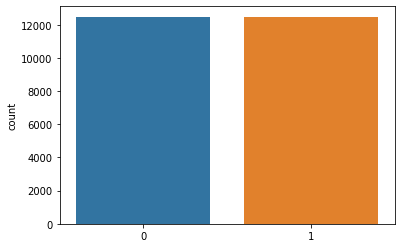

In [18]:
# you are free to use bar plot or pie-plot or count plot, etc. to plot the labels of train and test data and check if they are balanced

sns.countplot(train_labels)

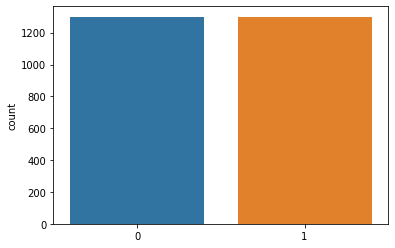

In [19]:
sns.countplot(test_labels)

#####<b> Observations and insights: Again, the data in the train and test sets are balanced between infected and non-infected cells. This will help us in ensuring there is enough representation on both sides to detect malaria-infected cells.

Some other questions are, how many patients were used to create this training and test set? Is there diversity in gender, age, race, etc? We want to make sure that the model doesn't only work for one gender or for a certain race. 

I would also want to know if the people with infected cells are known to have malaria - i.e. they have been diagnosed and they are in a more advanced state of the disease. It seems like these cells could be easier to detect than cells where the patient was newly infected by the parasite and was not yet diagnosed with malaria at the time the images were done. 

With that said, I'd like to know the process for how these images in the sample were obtained. They clearly weren't from a random sample, so what was the methodology used?

### <b>Data Exploration</b>
Let's visualize the images from the train data

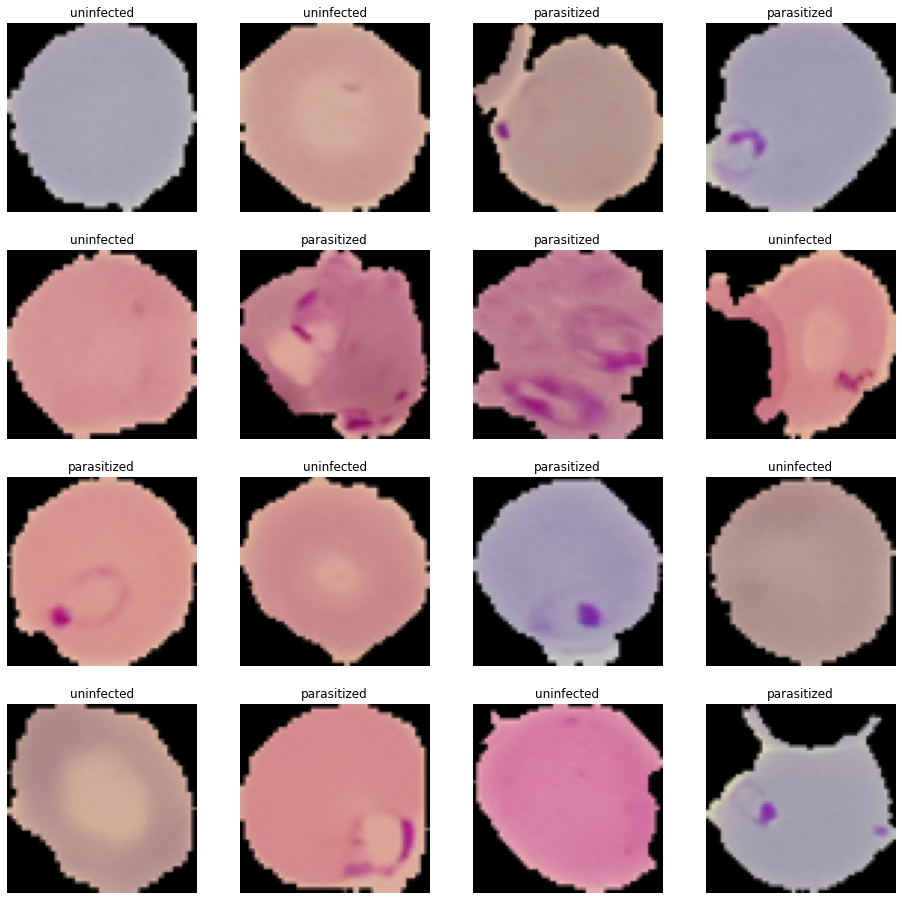

In [20]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

#####<b> Observations and insights: Based on the first few observations, it seems like there is practically no way to tell parasitized from infected with the naked eye. 
The only consistent rule I can see from this sub-sample of the data is that if there are red blotches inside the cell, it is parasitized. However, some parasitized cells have no red blothces inside them, and there is no rule to classify those as parasitized. 
Perhpas the parasitized ones are more likely to be an irregular shape, with jagged edges. But then some uninfected ones have that shape. 
Usually if a cell is empty and has a regular round shape it is uninfected - but even then some of those are infected.
I could see why a human classifier would be very inaccurate here.
It seems that whether the cell is red or blue has little to do with whether it is infected or not. But without statistical analysis, it is really hard to say. Perhaps some doctors have a good gut instinct as to which are infected vs uninfected, but it seems like there are not really a clear set of rules.

###<b> Similarly visualize the images with subplot(6,6) and figsize=(12,12)

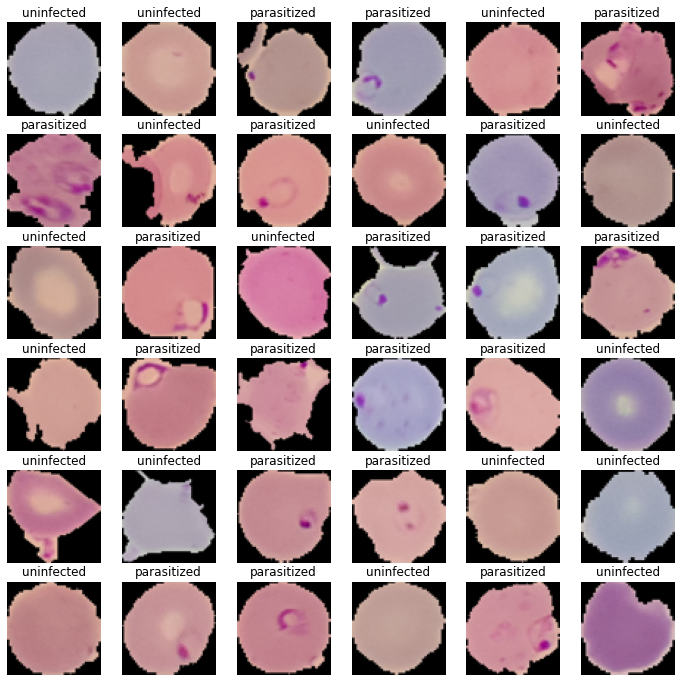

In [21]:
# Hint: Have a keen look into the number of iterations that the for loop should iterate
np.random.seed(42)
plt.figure(1 , figsize = (12 , 12))

for n in range(1, 37):
    plt.subplot(6, 6, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')


#####<b>Observations and insights: 
Seeing a larger sample, I can begin to identify a parastized from an uninfected cell. The ones with very irregular shapes and purple spots inside are clearly infected. But there are less obvious cells that are infected. The third cell in the third row is a good example of a cell with hardly any abnormalities but is infected. At the same time, the very first cell in the sample has an irregular shape and looks like it might be infected but it is not. It seems like a human classifier would have some luck but would make many mistakes. Hopefully a neural networks classification system will be more accurate and save a lot of time (and lives).

###<b> Plotting the mean images for parasitized and uninfected

In [22]:
# function to find the mean
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]
    # reshape it back to a matrix
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

<b> Mean image for parasitized

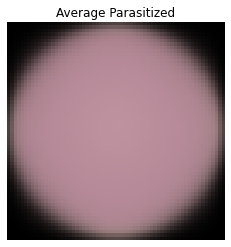

In [23]:
# If the label=1 then the image is parasitised and if the label=0 then the image is uninfected
parasitized_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==1:
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean


<b> Mean image for uninfected

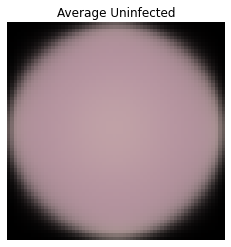

In [24]:
# Similarly write the code to find the mean image of uninfected
parasitized_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==0:
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Uninfected')   # find the mean



#####<b> Observations and insights: The average parasitized cell is more red than the average uninfected cell. This might be due to the presence of those purple spots that tend to be in infected cells. There is hardly any perceptible difference in the shape of the average parasitized and uninfected cell. It may be my imagination but the uninfected cells seem more circular and plump, while the parasitized are slightly less rounded. There is more blurring on the edge of the parasitized cell than the uninfected cell, indicating there might be more variation and irregular edges on the parasitized cells.

###<B>One Hot Encoding on the train and test labels

In [14]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [15]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [27]:

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [30]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 11s 13ms/step - loss: 0.4632 - accuracy: 0.7743 - val_loss: 0.2823 - val_accuracy: 0.9287
Epoch 2/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1787 - accuracy: 0.9374 - val_loss: 0.2058 - val_accuracy: 0.9263
Epoch 3/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1581 - accuracy: 0.9464 - val_loss: 0.1528 - val_accuracy: 0.9657
Epoch 4/20
624/624 [==============================] - 8s 12ms/step - loss: 0.1482 - accuracy: 0.9497 - val_loss: 0.1968 - val_accuracy: 0.9551
Epoch 5/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1420 - accuracy: 0.9529 - val_loss: 0.1471 - val_accuracy: 0.9641
Epoch 6/20
624/624 [==============================] - 8s 12ms/step - loss: 0.1359 - accuracy: 0.9543 - val_loss: 0.1604 - val_accuracy: 0.9603
Epoch 7/20
624/624 [==============================] - 7s 12ms/step - loss: 0.1302 - accuracy: 0.9556 - val_loss: 0.1864 - val_accuracy: 0.955

####<b> Evaluating the model on test data

In [31]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1671 - accuracy: 0.9458

 Test_Accuracy:- 0.9457692503929138


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1300
           1       0.95      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



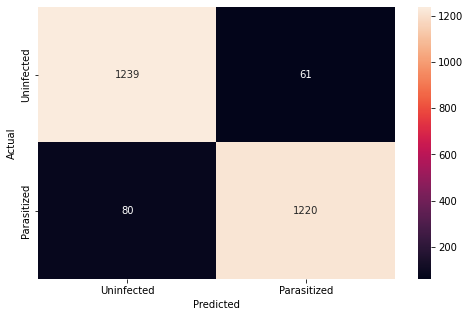

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [33]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

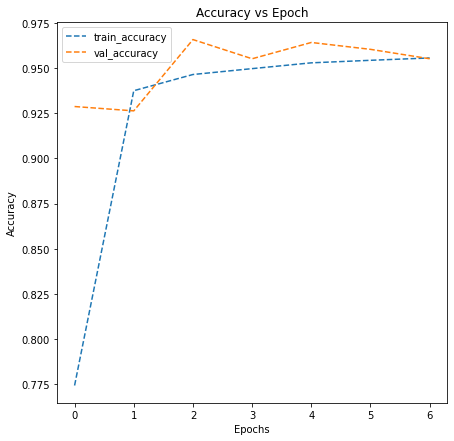

In [34]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [16]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [35]:
#Model 1.0
model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=512,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())

model1.add(Dense(256,activation="relu"))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 512)       14336     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       1179904   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

In [45]:
#Model 1.1
## With more layers and complexity

model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())

model1.add(Dense(256,activation="relu"))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       5

In [13]:
#Model 1.2
# With slightly less layers and complexity than model 1.1

model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model1.add(Conv2D(filters=256,kernel_size=5,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=5,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=7,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=256,kernel_size=7,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(256,activation="relu"))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       1638656   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0

In [ ]:
#creating sequential model 1.3
## With no dropout layers
model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())

model1.add(Dense(256,activation="relu"))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          1

In [ ]:
#creating sequential model 1.4
## With dropout 
model1=Sequential()

# Build the model here
model1.add(Conv2D(filters=128,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(256,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        3

####<b> Compiling the model

In [14]:
model1.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate = .1), metrics=['accuracy'])

<b> Using Callbacks

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [16]:
history1=model1.fit(train_images,train_labels,batch_size=128,callbacks=callbacks,  validation_split=.2,epochs=20,verbose=1)

Epoch 1/20
156/156 [==============================] - 331s 2s/step - loss: 5916755230720.0000 - accuracy: 0.5562 - val_loss: 1.0010 - val_accuracy: 0.0000e+00
Epoch 2/20
156/156 [==============================] - 245s 2s/step - loss: 0.6797 - accuracy: 0.6250 - val_loss: 1.0195 - val_accuracy: 0.0000e+00
Epoch 3/20
156/156 [==============================] - 246s 2s/step - loss: 0.6618 - accuracy: 0.6250 - val_loss: 0.9508 - val_accuracy: 0.0000e+00
Epoch 4/20
156/156 [==============================] - 246s 2s/step - loss: 0.6622 - accuracy: 0.6251 - val_loss: 0.9702 - val_accuracy: 0.0000e+00
Epoch 5/20
156/156 [==============================] - 246s 2s/step - loss: 0.6622 - accuracy: 0.6250 - val_loss: 1.0367 - val_accuracy: 0.0000e+00


####<b> Evaluating the model

In [17]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 23s 165ms/step - loss: 0.7373 - accuracy: 0.5000

 Test_Accuracy:- 0.5


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1300
           1       0.50      1.00      0.67      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



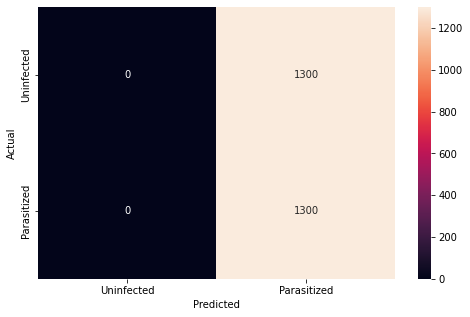

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

In [20]:
# function to plot train and validation accuracy 
def plot_accuracy(history1):
    N = len(history1.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history1.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history1.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")


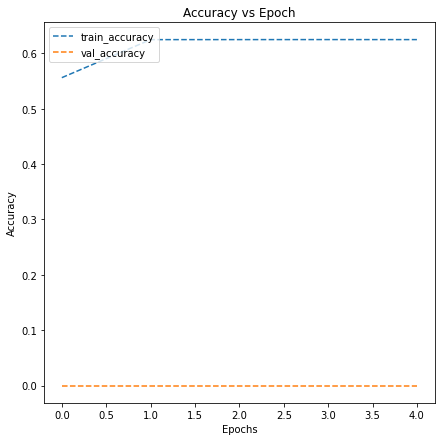

In [21]:
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [30]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [31]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add a LeakyRelu layer with the slope equal to 0.1
model2.add(LeakyReLU(0.1))

model2.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add LeakyRelu with the slope equal to 0.1
model2.add(LeakyReLU(0.1))

model2.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add a BatchNormalization layer
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add a LeakyRelu layer with slope equal to 0.1
model2.add(LeakyReLU(0.1))

model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add a LeakyRelu layer with slope equal to 0.1
model2.add(LeakyReLU(0.1))

### Add a BatchNormalization layer
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(256,activation="LeakyReLU"))
model2.add(Dropout(0.4))
model2.add(Dense(2,activation='softmax'))#2 represent output layer neurons 

adam = optimizers.Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [37]:
#Model 2.1
model2 = Sequential()

model2.add(Conv2D(256, (3,3), input_shape=(64, 64, 3), padding='same'))

model2.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

model2.add(Conv2D(filters=256,kernel_size=3,padding="same",activation="relu"))

### Add a BatchNormalization layer
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128,kernel_size=5,padding="same",activation="relu"))

### Add a LeakyRelu layer with slope equal to 0.1
model2.add(LeakyReLU(0.1))

model2.add(Conv2D(filters=128,kernel_size=5,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(filters=64,kernel_size=7,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=64,kernel_size=7,padding="same",activation="relu"))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))

### Add a LeakyRelu layer with slope equal to 0.1
model2.add(LeakyReLU(0.1))

### Add a BatchNormalization layer
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(256,activation="LeakyReLU"))
model2.add(Dense(2,activation='softmax'))#2 represent output layer neurons 

adam = optimizers.Adam(learning_rate=0.1)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       819328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       4

####<b>Compiling the model

In [32]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [33]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [34]:
history2 = model2.fit(train_images,train_labels,batch_size=128,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
156/156 [==============================] - 4s 18ms/step - loss: 0.5220 - accuracy: 0.7365 - val_loss: 0.2518 - val_accuracy: 0.9990
Epoch 2/20
156/156 [==============================] - 2s 16ms/step - loss: 0.1722 - accuracy: 0.9435 - val_loss: 0.1922 - val_accuracy: 0.9908
Epoch 3/20
156/156 [==============================] - 2s 16ms/step - loss: 0.1545 - accuracy: 0.9476 - val_loss: 0.1282 - val_accuracy: 0.9796
Epoch 4/20
156/156 [==============================] - 2s 16ms/step - loss: 0.1503 - accuracy: 0.9505 - val_loss: 0.2093 - val_accuracy: 0.9649
Epoch 5/20
156/156 [==============================] - 2s 16ms/step - loss: 0.1419 - accuracy: 0.9515 - val_loss: 0.3112 - val_accuracy: 0.9663


<b>Plotting the train and validation accuracy

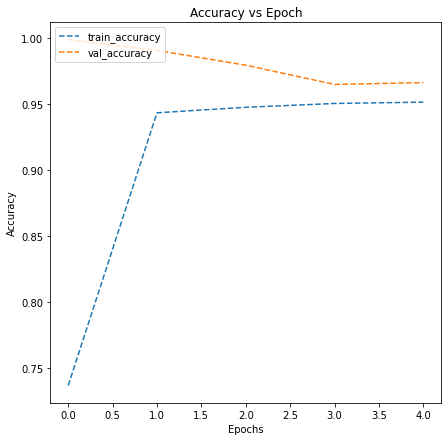

In [36]:
# plotting the accuracies
# function to plot train and validation accuracy 
def plot_accuracy(history2):
    N = len(history2.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history2.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history2.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history2)

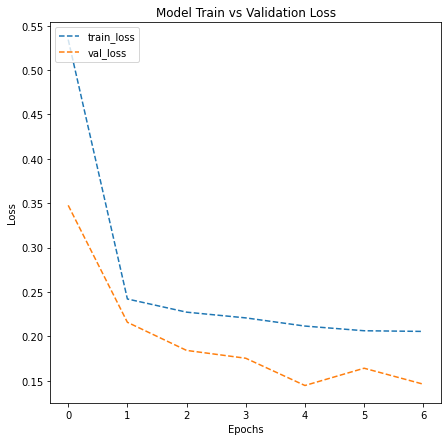

In [35]:
# plotting the loss
def plot_loss(history3):
    N = len(history3.history["loss"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history3.history["loss"], label="train_loss", ls='--')
    plt.plot(np.arange(0, N), history3.history["val_loss"], label="val_loss", ls='--')
    plt.title("Model Train vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

plot_loss(history3)

####<b>Evaluating the model

In [136]:
# Evaluate the model to calculate the accuracy
accuracy = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.2118 - accuracy: 0.9527

 Test_Accuracy:- 0.9526923298835754


#####<b>Observations and insights: Model 2 has an accuracy of 95.1% which is better than the Baseline model of 94.6%. 

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.67      0.31      0.43      1300
           1       0.55      0.85      0.67      1300

    accuracy                           0.58      2600
   macro avg       0.61      0.58      0.55      2600
weighted avg       0.61      0.58      0.55      2600



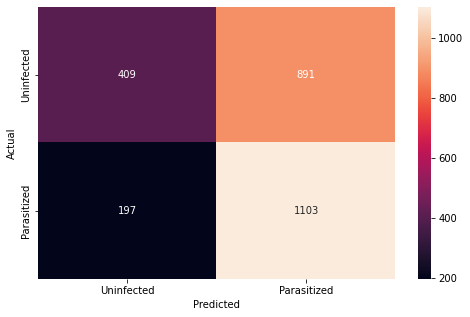

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [128]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, train_size=0.8, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = train_images, y = train_labels, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= test_images, y = test_labels, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

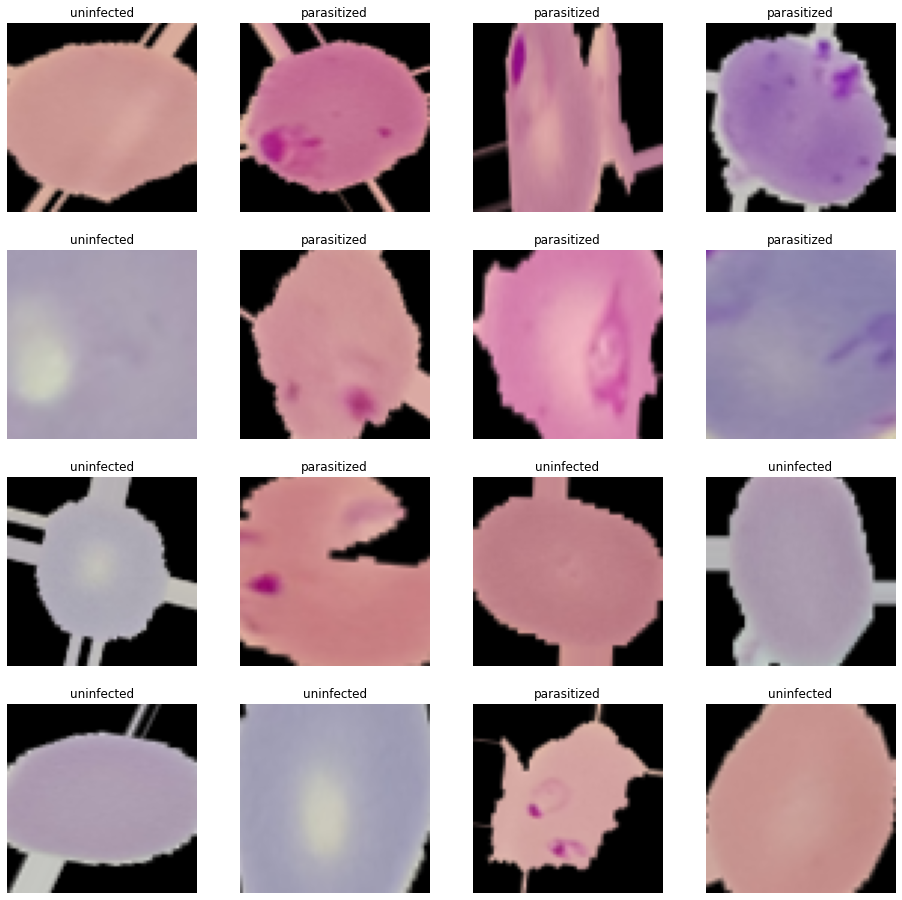

In [71]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1]: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights: The images generated from the image generator are black and white only. It seems that the complexity of the image is far reduced.

####<b>Building the Model

In [82]:
model3 = Sequential()

# Build the model here

model3.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(BatchNormalization())

model3.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(256,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [137]:
### Hyper parameter tuning of model 3

# model 3.1
# Use 7 layers instead of 5 

# model 3.2
# Back to 5 layers. Increase # of neurons

# model 3.3
# keep increased neurons. Reduce dropout

# model 3.4
# Put dropout layers back in as it caused overfitting.
# Try 128 and 64 neurons

# model 3.5
# go back to 64 and 32 neurons but in better order

# model 3.6
# went back to original model 3. Then changed learning rate to .01

# model 3.7
# Try changing kernel size to 3x3 and 5x5 

# model 3.8
# Use Adamax instead of Adam

# model 3.9
# use batch size 128 instead of 64


model3 = Sequential()

# Build the model here
model3.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(BatchNormalization())

model3.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(LeakyReLU(0.1))

model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(256,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)       

<b>Using Callbacks

In [138]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [139]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=64,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
390/390 [==============================] - 33s 83ms/step - loss: 0.6258 - accuracy: 0.6595 - val_loss: 0.3805 - val_accuracy: 0.8573
Epoch 2/20
390/390 [==============================] - 32s 82ms/step - loss: 0.2629 - accuracy: 0.9063 - val_loss: 0.1912 - val_accuracy: 0.9431
Epoch 3/20
390/390 [==============================] - 32s 81ms/step - loss: 0.2332 - accuracy: 0.9196 - val_loss: 0.1622 - val_accuracy: 0.9458
Epoch 4/20
390/390 [==============================] - 31s 81ms/step - loss: 0.2199 - accuracy: 0.9244 - val_loss: 0.2167 - val_accuracy: 0.9454
Epoch 5/20
390/390 [==============================] - 31s 80ms/step - loss: 0.2190 - accuracy: 0.9264 - val_loss: 0.1509 - val_accuracy: 0.9512
Epoch 6/20
390/390 [==============================] - 31s 80ms/step - loss: 0.2118 - accuracy: 0.9283 - val_loss: 0.2088 - val_accuracy: 0.9519
Epoch 7/20
390/390 [==============================] - 32s 82ms/step - loss: 0.2065 - accuracy: 0.9290 - val_loss: 0.1937 - val_accuracy:

####<B>Evaluating the model

<b>Plot the train and validation accuracy

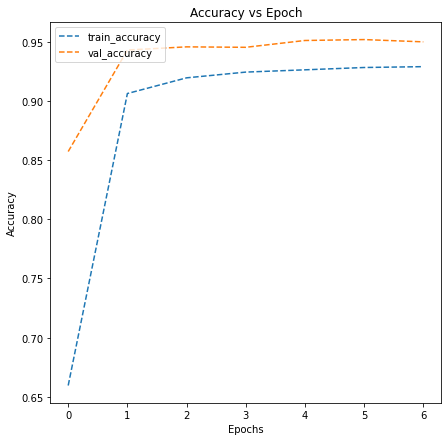

In [140]:
# plotting the accuracies
def plot_accuracy(history3):
    N = len(history3.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history3.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history3.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history3)

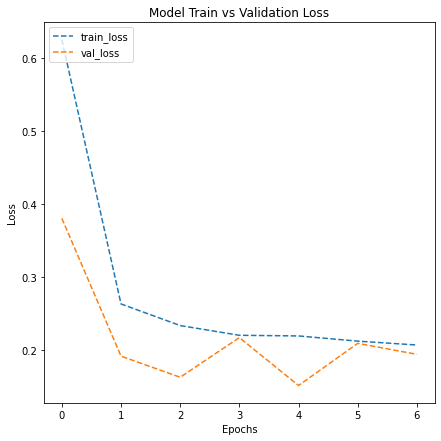

In [141]:
# plotting the loss
def plot_loss(history3):
    N = len(history3.history["loss"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history3.history["loss"], label="train_loss", ls='--')
    plt.plot(np.arange(0, N), history3.history["val_loss"], label="val_loss", ls='--')
    plt.title("Model Train vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

plot_loss(history3)

In [142]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.1937 - accuracy: 0.9500

 Test_Accuracy:- 0.949999988079071


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1300
           1       0.97      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



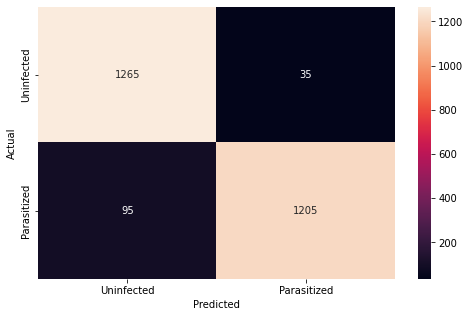

In [143]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [120]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [122]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [123]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)
x = Dense(128, activation ='relu')(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation ='relu')(x)

x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [124]:
# Compiling the model 

model4.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> using callbacks

In [125]:
# Adding Callbacks to the model

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [127]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(
            train_images, train_labels,
            epochs=10,
            callbacks=callbacks,
            batch_size=64,
            validation_split=0.2,
            verbose=1
)


Epoch 1/10
312/312 [==============================] - 7s 21ms/step - loss: 0.1929 - accuracy: 0.9253 - val_loss: 0.2964 - val_accuracy: 0.8840
Epoch 2/10
312/312 [==============================] - 6s 21ms/step - loss: 0.1838 - accuracy: 0.9286 - val_loss: 0.2692 - val_accuracy: 0.8910
Epoch 3/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1721 - accuracy: 0.9326 - val_loss: 0.1328 - val_accuracy: 0.9561


ValueError: ignored

<b>Plot the train and validation accuracy

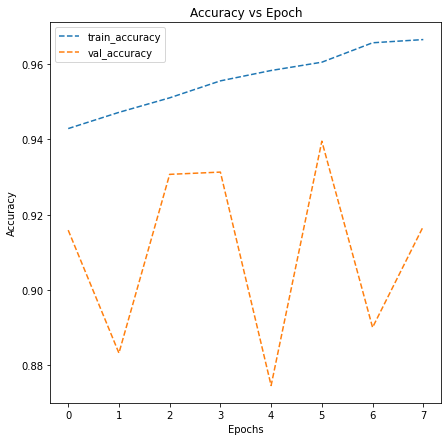

In [ ]:
# plotting the accuracies
# plotting the accuracies
def plot_accuracy(history4):
    N = len(history4.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history4.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history4.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

plot_accuracy(history4)

#####**Observations and insights: The model is wildly underfitted, with the test data accuracy far below that of the training data. The accuracy of the training data is up, then down, and is very volatile as each epoch progresses.  **

*   What can be observed from the validation and train curves?

####<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 81s 980ms/step - loss: 0.1808 - accuracy: 0.9377

 Test_Accuracy:- 0.9376922845840454


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



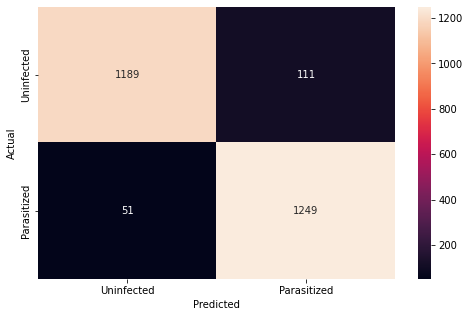

In [ ]:
# Plot the confusion matrix and generate a classification report for the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


###<b> Observations and Conclusions drawn from the final model: Model 4 is overfitted. Perhaps using a transfer model does not work for malaria cells.



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

###<b>Insights

**1.**  What are the most meaningful insights from the data relevant to the problem?

**2.  Comparison of various techniques and their relative performance:** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**3.  Proposal for the final solution design:** What model do you propose to be adopted? Why is this the best solution to adopt?

**4.  Key recommendations for implementation:** What are some key recommendations to implement the solutions? What should the implementation roadmap look like? What further analysis needs to be done or what other associated problems need to be solved?

See PDF for commentary.